<a href="https://colab.research.google.com/github/gustavoschmoeller/consumo-cerveja-sp/blob/main/projeto_awari_consumo_cerveja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CONSUMO DE CERVEJA - SÃO PAULO

#### Introdução

A cerveja é uma das bebidas mais democráticas e consumidas do mundo. Ela é perfeita para quase todas as situações, desde happy hour até grandes festas de casamento. Se você pensar bem, já deu vontade de tomar uma cerveja não é mesmo? Bom, você não está sozinho.

O objetivo deste trabalho será demonstrar os impactos das variáveis sobre o consumo de cerveja em uma determinada região e a previsão de consumo para determinados cenários. Os dados (amostra) foram coletados em São Paulo - Brasil, em uma área universitária, onde acontecem algumas festas com turmas de alunos de 18 a 28 anos (média).

Você pode obter mais informações sobre o dataset no site do kaggle: [Beer Consumption - Sao Paulo](https://www.kaggle.com/dongeorge/beer-consumption-sao-paulo)

In [ ]:
# Importando as bibliotecas

import requests
import json
import datetime
from datetime import date,timedelta


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
URL = 'https://api.openweathermap.org/data/2.5/onecall?lat=-23.5489&lon=-46.6388&exclude=hourly,current,minutely,alerts&units=metric&appid=6f14efc1f8a62b702f3104dc08bd0b36'

In [ ]:
data = requests.get(URL).content

In [ ]:
data_js = json.loads(data)
type(data_js)

dict

In [ ]:
data_js

{'daily': [{'clouds': 27,
   'dew_point': 12.44,
   'dt': 1605967200,
   'feels_like': {'day': 21.19, 'eve': 17.93, 'morn': 14.85, 'night': 15.74},
   'humidity': 52,
   'pop': 0.1,
   'pressure': 1017,
   'sunrise': 1605946334,
   'sunset': 1605994394,
   'temp': {'day': 22.8,
    'eve': 20.38,
    'max': 23.35,
    'min': 15.81,
    'morn': 16.53,
    'night': 17.57},
   'uvi': 13.67,
   'weather': [{'description': 'scattered clouds',
     'icon': '03d',
     'id': 802,
     'main': 'Clouds'}],
   'wind_deg': 139,
   'wind_speed': 3.37},
  {'clouds': 14,
   'dew_point': 11.49,
   'dt': 1606053600,
   'feels_like': {'day': 23.69, 'eve': 17.49, 'morn': 15.46, 'night': 16.55},
   'humidity': 40,
   'pop': 0.55,
   'pressure': 1018,
   'rain': 0.74,
   'sunrise': 1606032724,
   'sunset': 1606080836,
   'temp': {'day': 25.71,
    'eve': 20.03,
    'max': 25.71,
    'min': 16.39,
    'morn': 16.39,
    'night': 18.4},
   'uvi': 13.06,
   'weather': [{'description': 'light rain',
     'icon

In [ ]:
data_js['daily'][0]['temp']['max']

23.35

In [ ]:
time_pred = {'max':[],'min':[],'pop':[],'data':[]}

In [ ]:
for i in range(7):
  time_pred['max'].append(data_js['daily'][i]['temp']['max'])
  time_pred['min'].append(data_js['daily'][i]['temp']['min'])
  time_pred['pop'].append(data_js['daily'][i]['pop'])
  time_pred['data'].append(((date.today() + timedelta(days=i)).strftime(format='%y/%m/%d')))

In [ ]:
time_pred

{'data': ['20/11/21',
  '20/11/22',
  '20/11/23',
  '20/11/24',
  '20/11/25',
  '20/11/26',
  '20/11/27'],
 'max': [23.35, 25.71, 24.47, 27.37, 30.05, 30.34, 32.63],
 'min': [15.81, 16.39, 16.75, 17.57, 18.32, 20.94, 21.99],
 'pop': [0.1, 0.55, 0.47, 0.49, 0.62, 0.3, 0.63]}

In [ ]:
df_json = pd.DataFrame(time_pred)

In [ ]:
df_json

,max,min,pop,data
0,23.35,15.81,0.10,20/11/21
1,25.71,16.39,0.55,20/11/22
2,24.47,16.75,0.47,20/11/23
3,27.37,17.57,0.49,20/11/24
4,30.05,18.32,0.62,20/11/25
5,30.34,20.94,0.30,20/11/26
6,32.63,21.99,0.63,20/11/27


In [ ]:
# Importando o dataset em CSV

df = pd.read_csv('https://raw.githubusercontent.com/gustavoschmoeller/consumo-cerveja-sp/main/Consumo_cerveja.csv')
print(df.shape)
df.head(10)

(941, 7)


,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900
5,2015-01-06,"23,78","20,1","30,5","12,2",0.0,28.218
6,2015-01-07,24,"19,5","33,7",0,0.0,29.732
7,2015-01-08,"24,9","19,5","32,8","48,6",0.0,28.397
8,2015-01-09,"28,2","21,9",34,"4,4",0.0,24.886
9,2015-01-10,"26,76","22,1","34,2",0,1.0,37.937


### Carregando Dataset com os dias que contém feriados

In [ ]:
feriados = pd.read_csv('https://raw.githubusercontent.com/gustavoschmoeller/consumo-cerveja-sp/main/feriados_sao_paulo_2015.csv', sep=',')
feriados['Dia'] = pd.to_datetime(feriados['Dia'])
feriados

,Dia,Feriado
0,2015-01-01,Ano Novo
1,2015-01-25,Aniversário da Cidade
2,2015-02-16,Carnaval
3,2015-02-17,Carnaval
4,2015-02-18,Carnaval
5,2015-04-03,Sexta-Feira Santa
6,2015-04-03,Sexta-feira Santa
7,2015-04-21,Dia de Tiradentes
8,2015-05-01,Dia do Trabalho
9,2015-06-04,Corpus Christi


### Limpeza dos dados

In [ ]:
# Somando a quantidade de valores NaN

df.isnull().sum()

Data                           576
Temperatura Media (C)          576
Temperatura Minima (C)         576
Temperatura Maxima (C)         576
Precipitacao (mm)              576
Final de Semana                576
Consumo de cerveja (litros)    576
dtype: int64

In [ ]:
df.iloc[364:]

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
364,2015-12-31,"24,76","20,2",29,0,0.0,22.446
365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Retirando os valores NaN do dataset

df.dropna(inplace=True)
df.isnull().sum()

Data                           0
Temperatura Media (C)          0
Temperatura Minima (C)         0
Temperatura Maxima (C)         0
Precipitacao (mm)              0
Final de Semana                0
Consumo de cerveja (litros)    0
dtype: int64

In [ ]:
# Observando as informações do dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         365 non-null    object 
 1   Temperatura Media (C)        365 non-null    object 
 2   Temperatura Minima (C)       365 non-null    object 
 3   Temperatura Maxima (C)       365 non-null    object 
 4   Precipitacao (mm)            365 non-null    object 
 5   Final de Semana              365 non-null    float64
 6   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(2), object(5)
memory usage: 22.8+ KB


### Preparação dos dados

In [ ]:
# Final de semana de float para inteiro
df['Final de Semana'] = df['Final de Semana'].astype(int)

# Unidade de milhar removida do consumo e transformação para float
df['Temperatura Media (C)'] = df['Temperatura Media (C)'].str.replace(',', '.').astype('float64')
df['Temperatura Minima (C)'] = df['Temperatura Minima (C)'].str.replace(',', '.').astype('float64')
df['Temperatura Maxima (C)'] = df['Temperatura Maxima (C)'].str.replace(',', '.').astype('float64')
df['Precipitacao (mm)'] = df['Precipitacao (mm)'].str.replace(',', '.').astype('float64')

# Data de string para datetime
df['Data'] = pd.to_datetime(df['Data'])

df

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,27.30,23.9,32.5,0.0,0,25.461
1,2015-01-02,27.02,24.5,33.5,0.0,0,28.972
2,2015-01-03,24.82,22.4,29.9,0.0,1,30.814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29.799
4,2015-01-05,23.82,21.0,28.3,0.0,0,28.900
...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,1,32.307
361,2015-12-28,22.64,21.1,26.7,0.0,0,26.095
362,2015-12-29,21.68,20.3,24.1,10.3,0,22.309
363,2015-12-30,21.38,19.3,22.4,6.3,0,20.467


In [ ]:
# Usando o método info para confirmar a conversão do tipo das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Data                         365 non-null    datetime64[ns]
 1   Temperatura Media (C)        365 non-null    float64       
 2   Temperatura Minima (C)       365 non-null    float64       
 3   Temperatura Maxima (C)       365 non-null    float64       
 4   Precipitacao (mm)            365 non-null    float64       
 5   Final de Semana              365 non-null    int64         
 6   Consumo de cerveja (litros)  365 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 22.8 KB



### Criando novas colunas

In [ ]:
# Criação da coluna do mês
df['Mes'] = df['Data'].dt.month
df['Mes'] = df['Mes'].map({1:'Janeiro',2:'Fevereiro',3:'Março',4:'Abril',5:'Maio',6:'Junho',7:'Julho',8:'Agosto',9:'Setembro',
                           10:'Outubro',11:'Novembro',12:'Dezembro'})

# Criação da coluna de dia da semana

df['Dia da Semana'] = df['Data'].dt.dayofweek
df['Dia da Semana'] = df['Dia da Semana'].map({0:'Seg',1:'Ter',2:'Qua',3:'Qui',4:'Sex',5:'Sab',6:'Dom'})

# Identificação das observações que foram em feriados
df['Feriado'] = [dia in list(feriados['Dia']) for dia in df['Data']]

# Definição de dia útil ou não
df['Dia util'] = ~(df['Final de Semana'] | df['Feriado'])

# Trocando a colula final de semana de valores inteiros para strings
semana = {0:'Dia de semana', 1:'Final de semana'}
df['Final de Semana'] = df['Final de Semana'].apply(lambda x:semana[x])

feriado = {0:'Não é feriado', 1:'Feriado'}
df['Feriado'] = df['Feriado'].apply(lambda y:feriado[y])

dia_util = {0:'Não é dia util', 1:'Dia util'}
df['Dia util'] = df['Dia util'].apply(lambda z:dia_util[z])

# Conversão de bool para inteiro para as novas colunas: feriado e dia útil
#df['Feriado'] = df['Feriado'].astype(int)
#df['Dia util'] = df['Dia util'].astype(int)

df.head(5)

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros),Mes,Dia da Semana,Feriado,Dia util
0,2015-01-01,27.30,23.9,32.5,0.0,Dia de semana,25.461,Janeiro,Qui,Feriado,Não é dia util
1,2015-01-02,27.02,24.5,33.5,0.0,Dia de semana,28.972,Janeiro,Sex,Não é feriado,Dia util
2,2015-01-03,24.82,22.4,29.9,0.0,Final de semana,30.814,Janeiro,Sab,Não é feriado,Não é dia util
3,2015-01-04,23.98,21.5,28.6,1.2,Final de semana,29.799,Janeiro,Dom,Não é feriado,Não é dia util
4,2015-01-05,23.82,21.0,28.3,0.0,Dia de semana,28.900,Janeiro,Seg,Não é feriado,Dia util


In [ ]:
# Aplicando o método descibe para ver as descrições

df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Temperatura Media (C),365.0,21.23,3.18,12.90,19.02,21.38,23.28,28.86
Temperatura Minima (C),365.0,17.46,2.83,10.60,15.30,17.90,19.60,24.50
Temperatura Maxima (C),365.0,26.61,4.32,14.50,23.80,26.90,29.40,36.50
Precipitacao (mm),365.0,5.20,12.42,0.00,0.00,0.00,3.20,94.80
Consumo de cerveja (litros),365.0,25.40,4.40,14.34,22.01,24.87,28.63,37.94



### Visualizando o dataset

Perguntas a serem respondidas:

1 - Qual a variável de marior correlação no consumo de cerveja?

2 - A temperatura média influencia no consumo?

3 - Se consome mais cerveja em dias de semana, finais de semana, feriado ou dia util?

4 - Quais os dias da semana de maior consumo?

5 - Qual mês que mais se consome cerveja?

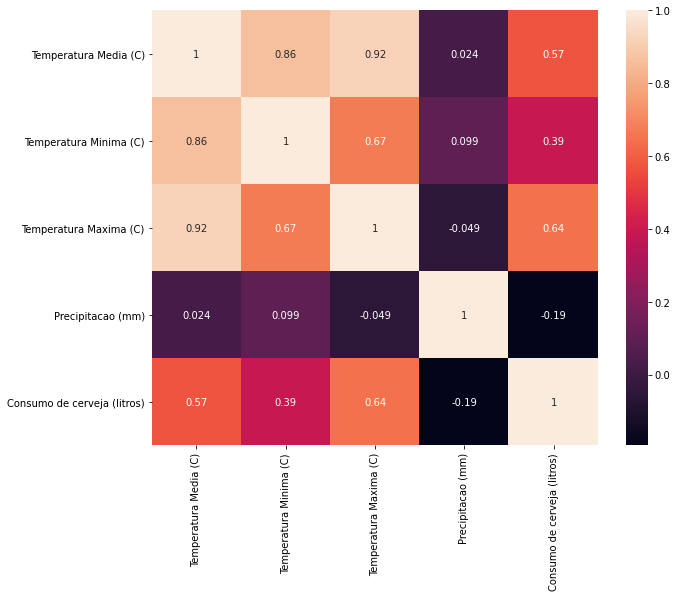

In [ ]:
#Verificar a correlação entre as variáveis

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)

1 - Qual a variável de marior correlação no consumo de cerveja?

R: Temperatura Máxima tem a maior correlação.

In [ ]:
# Agrupar por mês
df_mes = df.groupby(df['Mes'], as_index=False).mean()
df_mes.head(12)

,Mes,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Consumo de cerveja (litros)
0,Abril,20.837333,17.783333,25.966667,3.603333,24.624100
1,Agosto,19.900000,14.887097,26.316129,1.019355,25.908968
2,Dezembro,23.519355,19.741935,28.961290,10.261290,27.169516
3,Fevereiro,23.555000,19.935714,29.007143,9.750000,25.673143
4,Janeiro,25.218065,21.148387,31.490323,5.038710,28.677645
5,Julho,17.887097,14.209677,22.832258,2.100000,22.572871
6,Junho,18.070000,14.073333,23.220000,0.676667,23.627067
7,Maio,18.596774,15.612903,22.867742,1.635484,22.798387
8,Março,22.167097,19.012903,27.248387,10.732258,25.036387
9,Novembro,22.194000,18.850000,27.040000,8.240000,25.828200


In [ ]:
df_mes_ordenado = df_mes.sort_values(by='Temperatura Media (C)', ascending=True)

trace = go.Scatter(x= df_mes_ordenado['Temperatura Media (C)'],
                  y = df_mes_ordenado['Consumo de cerveja (litros)'])

data = [trace]

layout = go.Layout(title='Consumo de Ceveja relacionado a temperatura',
                   xaxis={'title':'Temperatura Media (C)'},
                   yaxis={'title':'Consumo de cerveja (litros)'})

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

2 - A temperatura média influencia no consumo?

R: Sim, há uma variação, mas a temperatura influencia no consumo

In [ ]:
df_consumo_semana = df.groupby(df['Final de Semana'], as_index=False).mean()
df_consumo_semana

,Final de Semana,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Consumo de cerveja (litros)
0,Dia de semana,21.328199,17.567433,26.721073,5.184291,23.998222
1,Final de semana,20.970769,17.195192,26.336538,5.227885,28.922721


In [ ]:
df_consumo_feriado = df.groupby(df['Feriado'], as_index=False).mean()
df_consumo_feriado

,Feriado,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Consumo de cerveja (litros)
0,Feriado,22.045556,18.061111,27.527778,11.938889,24.554556
1,Não é feriado,21.183862,17.430259,26.563977,4.846974,25.445294


In [ ]:
df_consumo_dia_util = df.groupby(df['Dia util'], as_index=False).mean()
df_consumo_dia_util

,Dia util,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Consumo de cerveja (litros)
0,Dia util,21.295102,17.542449,26.687347,4.678367,24.008278
1,Não é dia util,21.086000,17.295833,26.456667,6.255000,28.245592


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_consumo_semana['Final de Semana'],
    y=df_consumo_semana['Consumo de cerveja (litros)'],
    name='Consumo dia ou final de semana',
    marker_color='indianred'))

fig.add_trace(go.Bar(
    x=df_consumo_feriado['Feriado'],
    y=df_consumo_feriado['Consumo de cerveja (litros)'],
    name='Consumo feriado ou não feriado',
    marker_color='lightsalmon'))

fig.add_trace(go.Bar(
    x=df_consumo_dia_util['Dia util'],
    y=df_consumo_dia_util['Consumo de cerveja (litros)'],
    name='Consumo Dia util ou não dia util',
    marker_color='lightgoldenrodyellow'))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()


3 - Se consome mais cerveja em dias de semana, finais de semana, feriado ou dia util?

R: O consumo é maior nos finais de semana

In [ ]:
trace = go.Box(x= df['Dia da Semana'],
                  y = df['Consumo de cerveja (litros)'])

data = [trace]

layout = go.Layout(title='Consumo de cerveja nos dias da semana',
                   xaxis={'title':'Dia da semana'},
                   yaxis={'title':'Consumo de cerveja (litros)'})

fig = go.Figure(data=data, layout=layout)

fig.update_layout(barmode='stack', xaxis={'categoryorder':'array', 'categoryarray':['Seg','Ter','Qua','Qui','Sex','Sab','Dom']})

fig.update_traces(marker_color='darkgreen', marker_line_width=1.5, opacity=0.6)

py.iplot(fig)

4 - Quais os dias da semana de maior consumo?

R: Sábado e domingo

In [ ]:
trace = go.Bar(x = df_mes['Mes'],
                   y = df_mes['Consumo de cerveja (litros)'])

data = [trace]

layout = go.Layout(title='Meses com maiores consumos')

fig = go.Figure(data=data, layout=layout)

fig.update_layout(barmode='stack', xaxis={'categoryorder':'array', 'categoryarray':['Janeiro','Fevereiro','Março','Abril','Maio','Junho',
                                                                                    'Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.6)

py.iplot(fig)

5 - Qual mês que mais se consome cerveja?

R: Mês de janeiro

### Aplicando Regressão Linear

In [ ]:
df_onehot = pd.get_dummies(df)

In [ ]:
df_onehot.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Consumo de cerveja (litros),Final de Semana_Dia de semana,Final de Semana_Final de semana,Mes_Abril,Mes_Agosto,Mes_Dezembro,Mes_Fevereiro,Mes_Janeiro,Mes_Julho,Mes_Junho,Mes_Maio,Mes_Março,Mes_Novembro,Mes_Outubro,Mes_Setembro,Dia da Semana_Dom,Dia da Semana_Qua,Dia da Semana_Qui,Dia da Semana_Sab,Dia da Semana_Seg,Dia da Semana_Sex,Dia da Semana_Ter,Feriado_Feriado,Feriado_Não é feriado,Dia util_Dia util,Dia util_Não é dia util
0,2015-01-01,27.30,23.9,32.5,0.0,25.461,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
1,2015-01-02,27.02,24.5,33.5,0.0,28.972,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
2,2015-01-03,24.82,22.4,29.9,0.0,30.814,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
3,2015-01-04,23.98,21.5,28.6,1.2,29.799,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
4,2015-01-05,23.82,21.0,28.3,0.0,28.900,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0


In [ ]:
df_algoritimo = df_onehot.drop('Data', axis=1)

In [ ]:
X = df_algoritimo.drop('Consumo de cerveja (litros)', axis=1)
y = df_algoritimo['Consumo de cerveja (litros)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
lr = LinearRegression() 

In [ ]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predict_lr = lr.predict(X_test)

In [ ]:
erro_quadrado = mean_squared_error(y_test, predict_lr)
erro_quadrado

6.373092641620318

In [ ]:
erro = sqrt(erro_quadrado)
erro

2.524498493091315

In [ ]:
def predicao(algoritimo, X_train, X_test, y_train, y_test):
  algo = algoritimo
  algo.fit(X_train, y_train)
  predictions = algo.predict(X_test)
  erro_quadrado = mean_squared_error(y_test, predictions)
  rmse = sqrt(erro_quadrado)
  return rmse

In [ ]:
predicao(RandomForestRegressor(), X_train, X_test, y_train, y_test)

2.683243472785739

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



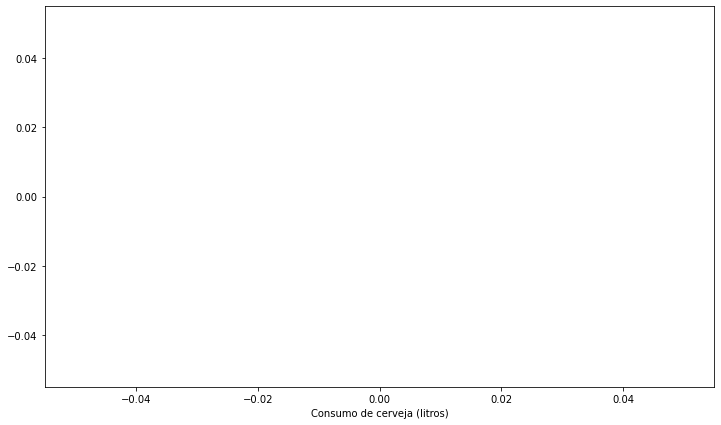

In [ ]:
plt.figure(figsize=(12,7))
sns.lineplot(y_test)
sns.lineplot(predict_lr)

### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'n_estimators': range(10,200,10), 'max_depth': range(10,100,5)}

In [ ]:
rf = RandomForestRegressor()

In [ ]:
gs_rf = GridSearchCV(rf, parameters)

In [ ]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [ ]:
gs_rf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=35, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
gs_rf.best_score_

0.6344006276509522